In [68]:
# self-define function
from data_cleaning import cleaning_text_MD, sentence_df
from participant_function import participants_list, clean_participants_list
# from stock_price_info import stock_price_change\
# read and saving path
path = "./meeting_transcript"
text_save_path = "./output_MD"
# other packages
import pdftotext
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import string
# nlp
import nltk 
nltk.download('twitter_samples')
from nltk.corpus import twitter_samples
from nltk.corpus import stopwords          # module for stop words that come with NLTK
nltk.download('stopwords')
from nltk.stem import PorterStemmer        # module for stemming
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import spacy 
nlp = spacy.load("en_core_web_lg")
from tqdm import tqdm
# tp_modelling packages
from collections import Counter, OrderedDict
from gensim.models import Phrases
import tomotopy as tp


[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/timliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [69]:
# call out the model_df CSV
model_df = pd.read_csv('./main_df_output/topic_modelling_MD_df.csv')
# model_df sort by date
model_df = model_df.sort_values(by=['date'])
pd.set_option('display.max_columns', None)
model_df.head()

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
5624,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,1.0,1,1,LEGAL -,Hello. Welcome to the U.S. capital restructuri...,Hello Welcome to the US capital restructuring ...,capital restructuring program call today instr...,"['capital', 'restructuring', 'program', 'today...",5,43,7,8.600000,0.714286
1090,Chris Knight,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,70.0,1,0,LEGAL -,18966542 (Technical difficulty) in-force ter...,Technical difficulty in-force term was re...,difficulty force term reinsurer FBARC x fundin...,"['difficulty', 'force', 'term', 'reinsurer', '...",147,977,46,6.646259,3.195652
4434,Luigi Lubelli,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,89.0,1,0,Mapfre SA,"4108780 Thank you, Esteban. Good afternoon t...",Thank you Good afternoon to everybody on t...,afternoon internet h slide breakdown premium p...,"['afternoon', 'internet', 'slide', 'breakdown'...",334,2283,106,6.835329,3.150943
3447,Jimmy Atkins,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,38.0,1,0,LEGAL -,"20917374 Thanks, Nigel. Since 1999, Legal & ...",Thanks Since Legal & LGA has focused ex...,thank writing term life life mortality protect...,"['write', 'term', 'life', 'life', 'mortality',...",80,572,32,7.150000,2.500000
2091,Esteban Tejera,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,0.0,1,0,Mapfre SA,"3910673 Good afternoon, ladies and gentlemen...",Good afternoon ladies and gentlemen Welcome...,afternoon lady gentleman year result presentat...,"['afternoon', 'lady', 'gentleman', 'year', 're...",222,1468,81,6.612613,2.740741


# Tokenize

In [70]:
def clean_tokens_nuon(text_series):
    # step 1: convert text_series df to list
    text_list = text_series.to_list()

    # step 2: change the list to lower case
    text_list = list(map(lambda x: x.lower(),text_list))

    # step 3: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    text_list=list(map(lambda x: remove_whitespace(x),text_list))

    # step 4: apply nlp pipeline remove stop words, numbers and lematize the words
    # expand the list of stopwords
    gist_file = open("./input/gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
        
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
        nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned text_list
    tokens, tmp_tokens = [], [] 
    for text in tqdm(text_list): # or tqdm.tqdm
        tmp_tokens = [
            token.lemma_
            for token in nlp(text)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        tokens.append(tmp_tokens)
        tmp_tokens=[]
    return tokens

In [71]:
# remove the numeric values from the 'paraghrph_clean' column by str.replace('\d+', '')
model_df['paraghrph_noun'] = model_df['paraghrph_noun'].str.replace('\d+', '')
model_df['paraghrph_noun']= model_df['paraghrph_noun'].astype(str)
# use apply to get the token of the paraghrph
model_df['token'] = clean_tokens_nuon(model_df['paraghrph_noun']) # or paraghrph_clean
model_df

/var/folders/sq/sxhsy98j6f57m406rd5lz1_r0000gn/T/ipykernel_5320/458752224.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.

100%|██████████| 8527/8527 [04:53<00:00, 29.01it/s] 


,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
5624,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,1.0,1,1,LEGAL -,Hello. Welcome to the U.S. capital restructuri...,Hello Welcome to the US capital restructuring ...,capital restructuring program call today instr...,"[capital, restructuring, program, today, instr...",5,43,7,8.600000,0.714286
1090,Chris Knight,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,70.0,1,0,LEGAL -,18966542 (Technical difficulty) in-force ter...,Technical difficulty in-force term was re...,difficulty force term reinsurer FBARC x fundin...,"[difficulty, force, term, reinsurer, fbarc, fu...",147,977,46,6.646259,3.195652
4434,Luigi Lubelli,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,89.0,1,0,Mapfre SA,"4108780 Thank you, Esteban. Good afternoon t...",Thank you Good afternoon to everybody on t...,afternoon internet h slide breakdown premium p...,"[afternoon, internet, slide, breakdown, premiu...",334,2283,106,6.835329,3.150943
3447,Jimmy Atkins,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,38.0,1,0,LEGAL -,"20917374 Thanks, Nigel. Since 1999, Legal & ...",Thanks Since Legal & LGA has focused ex...,thank writing term life life mortality protect...,"[write, term, life, life, mortality, protectio...",80,572,32,7.150000,2.500000
2091,Esteban Tejera,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,0.0,1,0,Mapfre SA,"3910673 Good afternoon, ladies and gentlemen...",Good afternoon ladies and gentlemen Welcome...,afternoon lady gentleman year result presentat...,"[afternoon, lady, gentleman, year, result, pre...",222,1468,81,6.612613,2.740741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,Mitra Hagen Negard,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,6.0,1,0,GJENSIDIGE FORSI-,"3974076 Thank you. Good morning, everyone. A...",Thank you Good morning everyone And welcome...,morning quer presentation name highlight quer ...,"[morning, quer, presentation, highlight, quer,...",8,49,8,6.125000,1.000000
3810,Jostein Amdal,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,130.0,1,0,GJENSIDIGE FORSI-,"19939645 Thank you, Helge, and good morning,...",Thank you and good morning everybody I'll ...,morning proﬁt tax quer year ium growth frequen...,"[morning, proﬁt, tax, quer, year, ium, growth,...",396,2545,119,6.426768,3.327731
2886,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,13.0,1,0,GJENSIDIGE FORSI-,"5865247 Thank you, Mitra. Good morning and w...",Thank you Good morning and welcome everyon...,morning world invasion uncertainty level decad...,"[morning, invasion, uncertainty, level, decade...",323,2159,99,6.684211,3.262626
2887,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,255.0,1,0,GJENSIDIGE FORSI-,"5865247 Thank you, Jostein. To sum up on Pag...",Thank you tein To sum up on Page we are ve...,result iver target year conﬁt growth eﬃcient o...,"[result, iver, target, year, conﬁt, growth, eﬃ...",27,176,9,6.518519,3.000000


In [74]:
# DTM模型（Dynamic Topic Models: 加入时间因素，不同主题随着时间变动) 时间-主题词条矩阵、主题-时间词条矩阵、文档主题偏好、新文档预测、跨时间+主题属性的文档相似性
# https://cloud.tencent.com/developer/article/1435976

model_df['date'] = pd.to_datetime(model_df['date'])
model_df['year'] = model_df['date'].apply(lambda x: x.year)
model_df['month'] = model_df['date'].apply(lambda x: x.month)
model_df['quater'] = model_df['date'].apply(lambda x: x.quarter)
model_df['year_quater'] = model_df['year'].astype(str) + '-' + model_df['quater'].astype(str)
# model_df['date'] to str
model_df['date'] = model_df['date'].astype(str)
model_df

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,year,month,quater,year_quater
5624,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,1.0,1,1,LEGAL -,Hello. Welcome to the U.S. capital restructuri...,Hello Welcome to the US capital restructuring ...,capital restructuring program call today instr...,"[capital, restructuring, program, today, instr...",5,43,7,8.600000,0.714286,2011,2,1,2011-1
1090,Chris Knight,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,70.0,1,0,LEGAL -,18966542 (Technical difficulty) in-force ter...,Technical difficulty in-force term was re...,difficulty force term reinsurer FBARC x fundin...,"[difficulty, force, term, reinsurer, fbarc, fu...",147,977,46,6.646259,3.195652,2011,2,1,2011-1
4434,Luigi Lubelli,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,89.0,1,0,Mapfre SA,"4108780 Thank you, Esteban. Good afternoon t...",Thank you Good afternoon to everybody on t...,afternoon internet h slide breakdown premium p...,"[afternoon, internet, slide, breakdown, premiu...",334,2283,106,6.835329,3.150943,2011,2,1,2011-1
3447,Jimmy Atkins,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,38.0,1,0,LEGAL -,"20917374 Thanks, Nigel. Since 1999, Legal & ...",Thanks Since Legal & LGA has focused ex...,thank writing term life life mortality protect...,"[write, term, life, life, mortality, protectio...",80,572,32,7.150000,2.500000,2011,2,1,2011-1
2091,Esteban Tejera,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,0.0,1,0,Mapfre SA,"3910673 Good afternoon, ladies and gentlemen...",Good afternoon ladies and gentlemen Welcome...,afternoon lady gentleman year result presentat...,"[afternoon, lady, gentleman, year, result, pre...",222,1468,81,6.612613,2.740741,2011,2,1,2011-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,Mitra Hagen Negard,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,6.0,1,0,GJENSIDIGE FORSI-,"3974076 Thank you. Good morning, everyone. A...",Thank you Good morning everyone And welcome...,morning quer presentation name highlight quer ...,"[morning, quer, presentation, highlight, quer,...",8,49,8,6.125000,1.000000,2022,4,2,2022-2
3810,Jostein Amdal,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,130.0,1,0,GJENSIDIGE FORSI-,"19939645 Thank you, Helge, and good morning,...",Thank you and good morning everybody I'll ...,morning proﬁt tax quer year ium growth frequen...,"[morning, proﬁt, tax, quer, year, ium, growth,...",396,2545,119,6.426768,3.327731,2022,4,2,2022-2
2886,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,13.0,1,0,GJENSIDIGE FORSI-,"5865247 Thank you, Mitra. Good morning and w...",Thank you Good morning and welcome everyon...,morning world invasion uncertainty level decad...,"[morning, invasion, uncertainty, level, decade...",323,2159,99,6.684211,3.262626,2022,4,2,2022-2
2887,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,255.0,1,0,GJENSIDIGE FORSI-,"5865247 Thank you, Jostein. To sum up on Pag...",Thank you tein To sum up on Page we are ve...,result iver target year conﬁt growth eﬃcient o...,"[result, iver, target, year, conﬁt, growth, eﬃ...",27,176,9,6.518519,3.000000,2022,4,2,2022-2


In [211]:
# drop the afternoon, morning, conference, today,lady, gentleman
model_df['token'] = model_df['token'].apply(lambda x: [i for i in x if i not in [
    'afternoon', 'morning', 'conference','today','lady', 'gentleman', 'presentation',
    'question','answer', 'slide',
    'proÔ¨Åt', 'eÔ¨Äect','proÔ¨Åtability','oÔ¨Ä','diÔ¨Äerent','eÔ¨Éciency','Ô¨Ågure','inÔ¨Çation','Ô¨Çow','conÔ¨Åt',
    'mm', 'mm_mm','guy','sir',' ','host_sir','bb','ty','word', 'year', 'quer','month','period', 'day', 'time','result', 'investor','week', 'update',
    'Ô¨Åre','diÔ¨Äerence','diÔ¨Écult','beneÔ¨Åt', 'business','lot','ratio','rate','quarter', 'number', 'point', 'term', 'thing', 'level', 
    'bit', 'sort', 'reason', 'management', 'fact', 'case', 'area', 'people', 'sense', 'item', 'issue','market'
     ]])
model_df

,participants,file_name,date,idx,company_paticipants_yes,other_paticipants_yes,company_name,paraghrph,paraghrph_clean,paraghrph_noun,token,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length,year,month,quater,year_quater
0,Operator,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,1.0,1,1,LEGAL -,Hello. Welcome to the U.S. capital restructuri...,Hello Welcome to the US capital restructuring ...,capital restructuring program call today instr...,"[capital, restructuring, program, instruction]",5,43,7,8.600000,0.714286,2011,2,1,2011-1
1,Chris Knight,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,70.0,1,0,LEGAL -,18966542 (Technical difficulty) in-force ter...,Technical difficulty in-force term was re...,difficulty force term reinsurer FBARC x fundin...,"[difficulty, force, reinsurer, fbarc, funding,...",147,977,46,6.646259,3.195652,2011,2,1,2011-1
2,Luigi Lubelli,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,89.0,1,0,Mapfre SA,"4108780 Thank you, Esteban. Good afternoon t...",Thank you Good afternoon to everybody on t...,afternoon internet h slide breakdown premium p...,"[internet, breakdown, premium, profit, activit...",334,2283,106,6.835329,3.150943,2011,2,1,2011-1
3,Jimmy Atkins,20110202_LEGAL_-_GEN_GRP-_Guidance_Call_2011-2...,2011-02-02,38.0,1,0,LEGAL -,"20917374 Thanks, Nigel. Since 1999, Legal & ...",Thanks Since Legal & LGA has focused ex...,thank writing term life life mortality protect...,"[write, life, life, mortality, protection, pro...",80,572,32,7.150000,2.500000,2011,2,1,2011-1
4,Esteban Tejera,20110202 _Mapfre_SA_Earnings_Call_SD0000000027...,2011-02-02,0.0,1,0,Mapfre SA,"3910673 Good afternoon, ladies and gentlemen...",Good afternoon ladies and gentlemen Welcome...,afternoon lady gentleman year result presentat...,"[overview, development, financial, standpoint,...",222,1468,81,6.612613,2.740741,2011,2,1,2011-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8522,Mitra Hagen Negard,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,6.0,1,0,GJENSIDIGE FORSI-,"3974076 Thank you. Good morning, everyone. A...",Thank you Good morning everyone And welcome...,morning quer presentation name highlight quer ...,[highlight],8,49,8,6.125000,1.000000,2022,4,2,2022-2
8523,Jostein Amdal,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,130.0,1,0,GJENSIDIGE FORSI-,"19939645 Thank you, Helge, and good morning,...",Thank you and good morning everybody I'll ...,morning proﬁt tax quer year ium growth frequen...,"[proﬁt, tax, ium, growth, frequency, loss, cos...",396,2545,119,6.426768,3.327731,2022,4,2,2022-2
8524,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,13.0,1,0,GJENSIDIGE FORSI-,"5865247 Thank you, Mitra. Good morning and w...",Thank you Good morning and welcome everyon...,morning world invasion uncertainty level decad...,"[invasion, uncertainty, decade, attack, democr...",323,2159,99,6.684211,3.262626,2022,4,2,2022-2
8525,Helge Leiro Baastad,20220427_GJENSIDIGE_FORSI-_Earnings_Call_2022-...,2022-04-27,255.0,1,0,GJENSIDIGE FORSI-,"5865247 Thank you, Jostein. To sum up on Pag...",Thank you tein To sum up on Page we are ve...,result iver target year conﬁt growth eﬃcient o...,"[iver, target, conﬁt, growth, eﬃcient, operati...",27,176,9,6.518519,3.000000,2022,4,2,2022-2


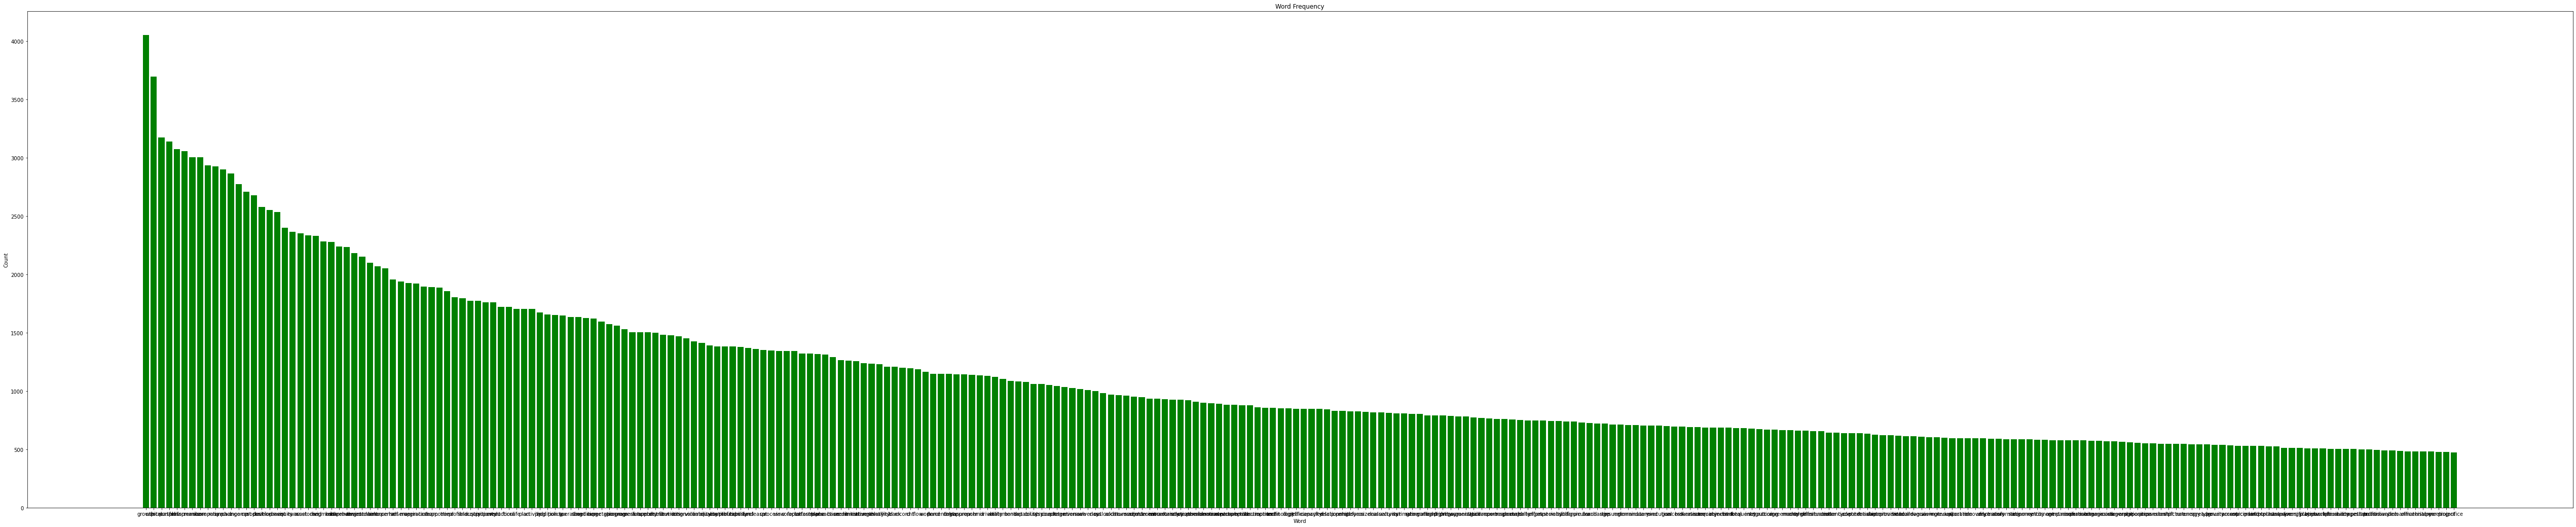

,word,freq
0,growth,4052
1,capital,3694
2,increase,3172
3,portfolio,3138
4,loss,3072
...,...,...
7551,petitioner,1
7552,xure,1
7553,awakening,1
7554,gpw,1


In [214]:
# exclude the rows that the sentence_count is less than 3
model_df = model_df[model_df['sentence_count']>4]
# reset the index
model_df = model_df.reset_index(drop=True)

# high frequency words excluding
temp_token = model_df['token'] # .apply(remove_brackets)
docs_tokens = []
for i in temp_token:
    docs_tokens.append(i)
    
# word frequency
# explore word frequencies
word_freq = Counter(x for xs in docs_tokens for x in set(xs)).most_common()
word_fr = pd.DataFrame(word_freq, columns=['word', 'freq']).sort_values(by='freq', ascending=False)

# visualize word frequencies
# figure size
fig = plt.figure(figsize=(90, 18))
plt.bar(word_fr.word[0:300], word_fr.freq[0:300], color='green')
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Word Frequency")
plt.show()

# remove 50 most frequent words which is known in this context
word_list = word_fr.head(300)['word'].to_list()
mdy_list, tmp=[],[]
for review in docs_tokens:
    for word in review:
        if word not in word_list:
            tmp.append(word)
    mdy_list.append(tmp)
    tmp=[]
    
word_fr

In [215]:
original_model_df = model_df.copy()

In [216]:
model_df['token'] = mdy_list

In [221]:
test_df = model_df.copy()
date_list = test_df['year_quater'].unique().tolist()
# if the date_list == test_df['date'], append to the dtm_list
dtm_token_list = []
dtm_token_df = []
dtm_df = pd.DataFrame()
for date in date_list:
    tmp_df = test_df[test_df['year_quater']==date]

    tmp_token_list = tmp_df['token'].to_list()
    for i in tmp_token_list:
        for k in i:
            dtm_token_list.append(k)
    dtm_token_df.append(dtm_token_list)
    dtm_token_list = []
    dtm_df['year_quater'] = date_list
dtm_df['token'] = dtm_token_df
# dtm_df drop the row 45
dtm_df = dtm_df.drop(45)
dtm_df = dtm_df.drop(44)
dtm_df = dtm_df.reset_index(drop=True)
dtm_df

,year_quater,token
0,2011-1,"[restructuring, instruction, difficulty, reins..."
1,2011-2,"[succession, cessation, repurchase, homeowner,..."
2,2011-3,"[breakdown, weight, merge, latin, contributor,..."
3,2011-4,"[financial, ium, sic, sic, mark, assurance, oc..."
4,2012-1,"[adequacy, agency, adequacy, diminution, disco..."
5,2012-2,"[consiation, histoal, reinstatement, rata, ehq..."
6,2012-3,"[aa, finance, webcast, stad, sharing, calculat..."
7,2012-4,"[restructuring, implementation, robustness, io..."
8,2013-1,"[proposal, king, rule, aa, webcast, proposal, ..."
9,2013-2,"[introduction, file, supplement, matter, webca..."


# Docs_tokens

In [222]:
# https://github.com/bab2min/tomotopy
# https://bab2min.github.io/tomotopy/v0.12.3/en/#tomotopy.DTModel
# https://notebook.community/pombredanne/gensim/docs/notebooks/ldaseqmodel

In [223]:
# recrate again for getting the docs_tokens
temp_token_dtm = dtm_df['token'] # .apply(remove_brackets)
docs_tokens_dtm = []
for i in temp_token_dtm:
    docs_tokens_dtm.append(i)
len(docs_tokens_dtm)

44

# docs_phrased

In [224]:
# topic modeling
common_terms = [
u"of",u"with",u"without",u"and",u"or",u"the",
u"a",u"not",u"be",u"to",u"this",u"who",u"in",
]

bigram_dtm = Phrases(                              
    docs_tokens_dtm,
    min_count=50, # 這邊可以調整字連起來
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
trigram_dtm = Phrases(                             
    bigram_dtm[docs_tokens_dtm],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# anks to these two models, 
# we can process the tokenized documents and join the tokens associated with bi- or tri-grams.
docs_phrased_dtm = [trigram_dtm[bigram_dtm[line]] for line in docs_tokens_dtm]
len(docs_tokens_dtm)

44

# corpus

In [225]:
corpus_dtm = tp.utils.Corpus() 
for i in range(len(docs_tokens_dtm)):
    # corpus_dtm.add_doc with timepoint
    corpus_dtm.add_doc(words=docs_tokens_dtm[i], timepoint=i) # dtm_df['date'][i]
print(len(corpus_dtm))

44


# model base on the topic number we select (without time series)

In [231]:
best_mdl = tp.DTModel(
    # tw= TermWeight.ONE, # term weighting scheme in TermWeight. The default value is TermWeight.ONE
    # min_cf=0, # minimum collection frequency of words
    # min_df=0, # minimum document frequency of words
    # rm_top=0, # remove top frequency words
    # transform=None, # transformation of the corpus
    k=10,
    t = len(dtm_df),
    corpus=corpus_dtm,
    seed = 1
    )


for i in range(0, 100, 10):
    best_mdl.train(10)
    print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))

Iteration: 0	Log-likelihood: -8.612592995992664
Iteration: 10	Log-likelihood: -8.545834248363686
Iteration: 20	Log-likelihood: -8.347373637346818
Iteration: 30	Log-likelihood: -8.052862062508533
Iteration: 40	Log-likelihood: -7.761760554379353
Iteration: 50	Log-likelihood: -7.5317686785549345
Iteration: 60	Log-likelihood: -7.354788704494243
Iteration: 70	Log-likelihood: -7.190707298095001
Iteration: 80	Log-likelihood: -7.065775164612186
Iteration: 90	Log-likelihood: -6.9626951542378706


In [232]:
wt = pd.DataFrame()
# 使用“get_topic_words”屬性，我們可以取得主題到詞彙概率的預測，with required argument 'timepoint' (pos 2)
for k in range(best_mdl.k):
    words, probs, timepoints = [], [], []
    for t in range(len(corpus_dtm)):
        for word, prob in best_mdl.get_topic_words(k ,timepoint=t):
            timepoints.append(t)
            words.append(word)
            probs.append(prob)
        tmp = pd.DataFrame(
            {
                "word": words,
                "prob": np.round(probs, 5),
                "timepoint": timepoints,
                "k": np.repeat(k, len(words)),
                "sort": np.arange(0, len(words)),
            }
        )
    words, probs, timepoints = [], [], []
    wt = wt.append(tmp)
    del tmp

wt

,word,prob,timepoint,k,sort
0,ehquake,0.00543,0,0,0
1,cover,0.00542,0,0,1
2,car,0.00542,0,0,2
3,reinsurer,0.00542,0,0,3
4,eﬀect,0.00409,0,0,4
...,...,...,...,...,...
435,creation,0.00246,43,9,435
436,disability,0.00245,43,9,436
437,culture,0.00241,43,9,437
438,housing,0.00240,43,9,438


In [233]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

td

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,timepoint
0,0.120549,0.137997,0.095670,0.085331,0.112472,0.090178,0.069822,0.100517,0.069822,0.117641,0
1,0.077171,0.097207,0.084457,0.111172,0.129994,0.089921,0.094778,0.111779,0.111779,0.091743,1
2,0.073793,0.107676,0.096882,0.145157,0.090585,0.103478,0.081889,0.082489,0.091184,0.126867,2
3,0.097325,0.116778,0.096717,0.074225,0.118602,0.086991,0.122249,0.091246,0.097325,0.098541,3
4,0.082638,0.076950,0.109995,0.106473,0.095910,0.127871,0.103765,0.099160,0.076679,0.120558,4
5,0.080952,0.084537,0.112698,0.109114,0.085049,0.116283,0.098874,0.091193,0.104506,0.116795,5
6,0.071748,0.094090,0.083640,0.121117,0.103459,0.123640,0.108865,0.082559,0.094450,0.116432,6
7,0.142429,0.089495,0.093599,0.101395,0.112474,0.109192,0.097292,0.107550,0.067747,0.078826,7
8,0.159104,0.059435,0.073549,0.091845,0.167642,0.094459,0.092020,0.082262,0.075815,0.103868,8
9,0.092516,0.099569,0.135619,0.109757,0.071356,0.084679,0.098393,0.099177,0.110541,0.098393,9


In [234]:
# save td to csv
td.to_csv('./main_df_output/MD_DTM_td_all_time.csv', index=False) 
wt.to_csv('./main_df_output/MD_DTM_wt_all_time.csv', index=False)

In [235]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

import plotly.express as px
fig = px.line(td, x="timepoint", y=td.columns,
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='All Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")
fig.show()

# save the figure to html
fig.write_html('./main_df_output/MD_DTM_topic_plot.html')

In [237]:
test = wt[wt['k']==9]
time_list = [39,42]
test = test[test['timepoint'].isin(time_list)]
# groupby word and get the average of prob
test = test.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
test.sort_values(by='prob', ascending=False, inplace=True)
test.T

,6,10,13,9,16,0,3,8,12,15,1,2,4,7,11,5,14
word,inflation,pandemic,sustainability,mortality,wave,climate,death,legacy,resince,vaccine,crisis,cyber,framework,ivery,purpose,guarantee,transfer
prob,0.00661,0.0061,0.00462,0.00437,0.00292,0.00277,0.00275,0.00274,0.00268,0.00243,0.00239,0.00238,0.00232,0.0022,0.002185,0.00204,0.00204


In [163]:
test = wt[wt['k']==1]
time_list = [3,4,22,43,44,45]
test = test[test['timepoint'].isin(time_list)]
# groupby word and get the average of prob
test = test.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
test.sort_values(by='prob', ascending=False, inplace=True)
test.T

,8,14,3,5,15,1,7,20,18,0,19,16,17,11,10,22,12,9,4,13,21,6,2
word,growth,loss,claim,customer,performance,capital,divid,segment,product,asset,profit,portfolio,premium,income,impact,target,increase,half,cost,inﬂation,share,development,cash
prob,0.019423,0.018685,0.01526,0.014873,0.01481,0.012922,0.01082,0.01067,0.01055,0.010425,0.01036,0.010252,0.010044,0.009495,0.009417,0.0091,0.009097,0.008645,0.00861,0.00808,0.00756,0.00754,0.00687


# During the early of time 

In [136]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

tp_slelcted = [2, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 19, 20, 24, 25, 27, 29, 30, 31, 32, 33, 35, 36, 40, 42, 43, 47]
topic_list = []
for i in tp_slelcted:
    topic_list.append(f"topic_{i}")

import plotly.express as px
fig = px.line(td, x="timepoint", y=topic_list,
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='Early Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")
fig.show()

In [138]:
MD_DTM_early = pd.DataFrame()
for i in tp_slelcted:
    tmp_topic = wt[wt['k']==i-1]
    MD_DTM_early = MD_DTM_early.append(tmp_topic)


time_list = []
for i in range(12):
    time_list.append(i)

# MD_DTM_early['k'] is in any of the time_list
MD_DTM_early = MD_DTM_early[MD_DTM_early['timepoint'].isin(time_list)]

print(MD_DTM_early.k.unique())
print(MD_DTM_early.timepoint.unique())

# groupby word and get the average of prob
MD_DTM_early = MD_DTM_early.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
MD_DTM_early.sort_values(by='prob', ascending=False, inplace=True)
MD_DTM_early.T

[ 2  3  8 10 17 22 25 27 43 45]
[ 0  1  2  3  4  5  6  7  8  9 10 11]


,25,52,86,20,103,63,72,147,141,140,27,98,29,31,0,33,95,88,24,37,87,79,36,57,8,22,121,2,128,133,3,135,12,11,145,65,66,75,118,139,138,134,110,84,83,77,46,100,129,146,64,126,76,47,148,109,38,150,137,16,58,143,102,49,132,10,32,34,116,15,80,81,62,44,115,85,41,151,73,90,104,68,144,97,6,35,61,67,122,142,13,26,60,71,125,124,127,1,69,21,107,50,114,42,56,39,14,48,40,101,7,28,106,130,94,70,23,55,19,120,78,119,30,111,18,131,92,113,4,91,43,17,53,54,99,9,123,74,45,108,136,59,105,117,96,5,82,51,93,89,112,149
word,contribution,feature,mic,circle,possibility,health,individual,unwriter,sustainability,surplus,cover,platform,cut,degree,access,dialing,picipant,movement,conclusion,distinction,mismatch,leave,discount,frequency,boat,cluster,reporting,appeal,selection,silo,aspiration,staff,capacity,break,track,hold,idea,initiative,reinsurer,superior,summary,size,progress,maturity,mark,integration,exchange,policymaker,set,traction,healthcare,scheme,insurer,expansion,unwriting,program,distribution,volatility,structure,cat,fund,tax,position,exposure,sheet,book,development,disaster,region,casualty,life,loss,half,equity,reduction,meeting,ehquake,yen,industry,operation,premium,impairment,total,plan,bank,discip,growth,impact,reserve,target,capital,cost,gain,increase,sale,return,segment,acquisition,improvement,claim,profit,extent,rating,employee,forecast,divid,cash,expense,earn,portfolio,basis,customer,product,share,performance,income,company,focus,channel,release,lapse,relationship,debt,property,change,sharehol,pension,quality,asset,opportie,environment,catastrophe,figure,flow,policy,bond,retention,inflow,event,profitability,strength,future,process,reinstatement,ping,balance,margin,eﬀect,percentage,net,protection,vitality
prob,0.1,0.1,0.1,0.1,0.1,0.063,0.063,0.063,0.063,0.063,0.0565,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.056,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.049,0.042,0.042,0.042,0.042,0.042,0.042,0.036,0.036,0.036,0.036,0.036,0.0325,0.0305,0.02825,0.025333,0.0225,0.0206,0.0192,0.0186,0.018,0.01775,0.017333,0.0161,0.014526,0.014,0.013,0.013,0.012476,0.012409,0.012389,0.01235,0.012,0.012,0.012,0.011333,0.011333,0.011143,0.011101,0.011,0.011,0.011,0.011,0.011,0.010926,0.01081,0.010727,0.010667,0.010535,0.010525,0.010333,0.010263,0.010263,0.0102,0.010188,0.010167,0.010143,0.010129,0.010077,0.01,0.01,0.01,0.01,0.009889,0.009857,0.009778,0.009571,0.009545,0.009444,0.009412,0.009295,0.009174,0.009143,0.009102,0.009091,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.008889,0.008833,0.008667,0.0085,0.0085,0.0085,0.0084,0.0084,0.00825,0.00825,0.0082,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.0078,0.007667,0.007,0.007,0.007,0.006,0.006


# During the recent of time 

In [149]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

tp_slelcted = [21, 11, 28, 18] #[3, 4 ,9, 11, 18,21, 23, 26, 28, 44, 46]
topic_list = []
for i in tp_slelcted:
    topic_list.append(f"topic_{i}")

import plotly.express as px
fig = px.line(td, x="timepoint", y=topic_list,
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='Recent Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")
fig.show()

In [150]:
MD_DTM_recent = pd.DataFrame()
for i in tp_slelcted:
    tmp_topic = wt[wt['k']==i-1]
    MD_DTM_recent = MD_DTM_recent.append(tmp_topic)


time_list = []
for i in range(30,46):
    time_list.append(i)

MD_DTM_recent = MD_DTM_recent[MD_DTM_recent['timepoint'].isin(time_list)]

print(MD_DTM_recent.k.unique())
print(MD_DTM_recent.timepoint.unique())

# groupby word and get the average of prob
MD_DTM_recent = MD_DTM_recent.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
MD_DTM_recent.sort_values(by='prob', ascending=False, inplace=True)
MD_DTM_recent.T

[20 10 27 17]
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


,46,90,3,23,43,87,1,9,75,11,57,18,69,63,48,58,74,66,73,30,80,83,88,89,33,92,22,15,6,24,17,36,16,68,85,78,4,38,50,65,49,20,71,59,61,44,54,84,37,2,91,72,60,76,45,77,81,42,41,40,34,79,7,86,64,0,39,62,67,31,32,56,21,82,19,52,70,47,10,26,25,55,14,12,5,27,53,8,35,51,29,13,28
word,peer,wholesale,amendment,financing,operating,venture,alliance,certainty,stuff,colleague,reconciliation,direction,settlement,resse,placement,regulator,statement,schedule,stake,inflow,thumb,transfer,view,wake,labor,ﬂeet,expectation,debt,bur,function,digital,manufacture,decennium,session,trend,target,announcement,match,policy,scenario,pner,drag,society,relation,renewable,opporty,preparation,transformation,margin,alpha,yesterday,solvency,release,support,path,synergy,track,omnichannel,motor,money,lion,tein,capacity,unstanding,return,agreement,momentum,report,segment,ing,inﬂation,program,equity,transaction,divid,position,share,performance,claim,half,growth,product,customer,company,asset,impact,premium,capital,loss,portfolio,increase,cost,income
prob,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.167,0.167,0.167,0.1665,0.1415,0.128,0.125,0.125,0.125,0.0875,0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.056,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.033,0.033,0.033,0.033,0.028,0.028,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.019333,0.018,0.0068,0.006333,0.004609,0.004333,0.003635,0.002889,0.002883,0.002846,0.002824,0.002784,0.002347,0.001717,0.001667,0.001236,0.000958,0.0009,0.000571


In [152]:
MD_DTM_recent = pd.DataFrame()
for i in tp_slelcted:
    tmp_topic = wt[wt['k']==i-1]
    MD_DTM_recent = MD_DTM_recent.append(tmp_topic)


time_list = []
for i in range(40,46):
    time_list.append(i)

MD_DTM_recent = MD_DTM_recent[MD_DTM_recent['timepoint'].isin(time_list)]

print(MD_DTM_recent.k.unique())
print(MD_DTM_recent.timepoint.unique())

# groupby word and get the average of prob
MD_DTM_recent = MD_DTM_recent.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
MD_DTM_recent.sort_values(by='prob', ascending=False, inplace=True)
MD_DTM_recent.T

[20 10 27 17]
[40 41 42 43 44 45]


,34,65,1,23,67,66,4,49,59,12,11,26,63,57,53,51,62,45,43,40,36,32,27,68,2,14,54,24,33,48,55,56,60,44,31,30,29,58,64,5,47,0,28,42,50,22,21,61,46,15,13,38,52,7,41,16,10,18,3,35,39,8,25,9,17,6,20,19,37
word,peer,venture,alliance,labor,wake,view,bur,schedule,thumb,digital,decennium,manufacture,trend,target,society,session,transformation,renewable,relation,preparation,pner,opporty,margin,yesterday,alpha,drag,solvency,lion,path,scenario,support,synergy,track,release,omnichannel,motor,money,tein,unstanding,capacity,return,agreement,momentum,program,segment,inﬂation,ing,transaction,report,equity,divid,position,share,claim,product,growth,customer,impact,asset,performance,premium,company,loss,cost,half,capital,increase,income,portfolio
prob,0.5,0.5,0.5,0.25,0.25,0.25,0.25,0.25,0.25,0.167,0.167,0.167,0.1415,0.128,0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.083,0.056,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.033,0.033,0.033,0.033,0.028,0.028,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.019333,0.018,0.017,0.009636,0.009286,0.009174,0.007762,0.007357,0.006833,0.006333,0.006294,0.005,0.004647,0.0045,0.004333,0.0042,0.003538,0.0035,0.003471


# early time of the common topics

In [285]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

import plotly.express as px
fig = px.line(td, x="timepoint", y=['topic_1', 'topic_10', 'topic_11', 'topic_12', 'topic_19', 'topic_21'],
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='Early Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")
fig.show()


In [264]:
# - 1 > timep 4, 45
# - 21 > timep 45, 4
# - 11 > timep 4, 45
# - 12 > timep 44, 1
# - 10 > timep 11, 45
# - 19 > timep 9, 12

# topic_1
topic_1 = wt[wt['k']==0] # start with 0
# select timepoint
topic_1_4 = topic_13[topic_13['timepoint']==4]
topic_1_45 = topic_13[topic_13['timepoint']==45]
# concat
topic_1_concate = pd.concat([topic_1_4, topic_1_45], ignore_index=True)
topic_1_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_10
topic_10 = wt[wt['k']==9] # start with 0
# select timepoint
topic_10_11 = topic_10[topic_10['timepoint']==11]
topic_10_45 = topic_10[topic_10['timepoint']==45]
# concat 
topic_10_concate = pd.concat([topic_10_11, topic_10_45], ignore_index=True)
topic_10_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_11
topic_11= wt[wt['k']==10] # start with 0
# select timepoint
topic_11_4 = topic_11[topic_11['timepoint']==4]
topic_11_45 = topic_11[topic_11['timepoint']==45]
# concat
topic_11_concate = pd.concat([topic_11_4, topic_11_45], ignore_index=True)
topic_11_concate.sort_values(by='prob', ascending=False, inplace=True)

# topic_12
topic_12= wt[wt['k']==11] # start with 0
# select timepoint
topic_12_44 = topic_12[topic_12['timepoint']==44]
topic_12_1 = topic_12[topic_12['timepoint']==1]
# concat 
topic_12_concat = pd.concat([topic_12_44, topic_12_1], ignore_index=True)
topic_12_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_19
topic_19 = wt[wt['k']==18] # start with 0
# select timepoint
topic_19_9 = topic_19[topic_19['timepoint']==9]
topic_19_12 = topic_19[topic_19['timepoint']==12]
# concat 
topic_19_concat = pd.concat([topic_19_9, topic_19_12], ignore_index=True)
topic_19_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_21
topic_21 = wt[wt['k']==20] # start with 0
# select timepoint
topic_21_45 = topic_21[topic_21['timepoint']==45]
topic_21_4 = topic_21[topic_21['timepoint']==4]
# concat 
topic_21_concat = pd.concat([topic_21_45, topic_21_4], ignore_index=True)
topic_21_concat.sort_values(by='prob', ascending=False, inplace=True)

In [266]:
# concat all together
topic_all_early = pd.concat([topic_1_concate, topic_10_concate, topic_11_concate, topic_12_concat, topic_19_concat, topic_21_concat], ignore_index=True)

# groupby word and get the average of prob
topic_all_early = topic_all_early.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
topic_all_early.sort_values(by='prob', ascending=False, inplace=True)
topic_all_early.T

,79,77,25,18,58,28,39,43,62,21,40,9,47,54,56,60,63,45,70,83,19,8,36,55,52,76,1,30,71,12,41,35,67,64,74,78,10,20,34,48,82,81,57,24,72,49,31,26,29,32,4,68,5,65,16,22,15,59,50,80,73,75,0,61,23,2,3,6,7,11,13,14,17,27,53,33,38,44,46,42,69,66,51,37
word,wage,synergy,ehquake,destruction,player,estate,instance,inﬂation,proﬁt,diﬀerent,instrument,building,majority,overview,oﬀset,procurement,proﬁtability,ium,sensitivity,yen,discount,beneﬁts,housing,oﬀ,motor,structure,adjustment,eﬀect,situation,capacity,integration,health,retention,qbe,stock,traction,buyback,discussion,gbpb,material,winter,website,pension,efficiency,statement,meeting,fall,element,extent,financial,annuity,revenue,assumption,relationship,crop,dollar,crisis,problem,mind,weather,step,storm,accit,protection,duration,adtage,agent,auto,bank,capability,class,competitor,decrease,energy,movement,force,inflow,item,load,investor,save,respect,money,impairment
prob,0.039,0.032,0.02,0.019,0.019,0.019,0.019,0.019,0.0165,0.016333,0.016,0.016,0.016,0.016,0.016,0.015,0.0145,0.014,0.014,0.014,0.014,0.014,0.013,0.013,0.013,0.0125,0.011,0.0105,0.0105,0.009,0.009,0.0085,0.008,0.008,0.0075,0.007,0.007,0.007,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.006,0.0055,0.005333,0.005333,0.005,0.005,0.005,0.005,0.005,0.005,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.0035,0.0035,0.0035,0.003


In [ ]:
ehquake, destruction, estate, instrument, building, yen, housing

# recent time of the common topics

In [284]:
td = pd.DataFrame()
for timepoint in range(best_mdl.num_timepoints):
    td_tmp = pd.DataFrame(
        np.stack([doc.get_topic_dist() for doc in best_mdl.docs if doc.timepoint == timepoint]),
        columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
    )
    td_tmp["timepoint"] = timepoint
    td = pd.concat([td, td_tmp], ignore_index=True)
    del td_tmp

import plotly.express as px
fig = px.line(td, x="timepoint", y=['topic_3', 'topic_4', 'topic_5', 'topic_17', 'topic_22'],
            #   hover_data={"timepoint": "|%B %d, %Y"},
              title='Recent Time Period Common Topics')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b %d",
    ticklabelmode="period")
fig.show()

In [272]:
# - 5 > timep 43
# - 17 > timep 40, 36, 42
# - 4 > timep 34, 35, 41
# - 3 > timep 39, 37, 30
# - 22 > timep 38, 33

# topic_3
topic_3= wt[wt['k']==2] # start with 0
# select timepoint
topic_3_39 = topic_3[topic_3['timepoint']==39]
topic_3_37 = topic_3[topic_3['timepoint']==37]
topic_3_30 = topic_3[topic_3['timepoint']==30]
# concat 
topic_3_concat = pd.concat([topic_3_39, topic_3_37, topic_3_30], ignore_index=True)
topic_3_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_4
topic_4 = wt[wt['k']==3] # start with 0
# select timepoint
topic_4_34 = topic_4[topic_4['timepoint']==34]
topic_4_35 = topic_4[topic_4['timepoint']==35]
topic_4_41 = topic_4[topic_4['timepoint']==41]
# concat 
topic_4_concat = pd.concat([topic_4_34, topic_4_35, topic_4_41], ignore_index=True)
topic_4_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_5
topic_5 = wt[wt['k']==4] # start with 0
# select timepoint
topic_5_43 = topic_21[topic_21['timepoint']==43]
# concat 
topic_5_concat = topic_5_43.copy()
topic_5_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_17
topic_17 = wt[wt['k']==16] # start with 0
# select timepoint
topic_17_40 = topic_17[topic_17['timepoint']==40]
topic_17_36 = topic_17[topic_17['timepoint']==36]
topic_17_4 = topic_17[topic_17['timepoint']==4]
# concat 
topic_17_concat = pd.concat([topic_17_40, topic_17_36, topic_17_4], ignore_index=True)
topic_17_concat.sort_values(by='prob', ascending=False, inplace=True)

# topic_22
topic_22= wt[wt['k']==21] # start with 0
# select timepoint
topic_22_38 = topic_22[topic_22['timepoint']==38]
topic_22_33 = topic_22[topic_22['timepoint']==33]
# concat 
topic_22_concat = pd.concat([topic_22_38, topic_22_33], ignore_index=True)
topic_22_concat.sort_values(by='prob', ascending=False, inplace=True)


In [289]:
# concat all together
topic_all_recently = pd.concat([topic_3_concat, topic_4_concat, topic_5_concat, topic_17_concat, topic_22_concat], ignore_index=True)
# groupby word and get the average of prob
topic_all_recently = topic_all_recently.groupby(['word'])['prob'].mean().reset_index()
# sort by prob
topic_all_recently.sort_values(by='prob', ascending=False, inplace=True)
topic_all_recently.T

,68,60,64,12,29,15,65,54,40,13,52,18,14,31,67,66,48,38,25,11,36,28,33,4,23,10,50,21,49,41,61,53,44,24,8,5,47,55,56,51,46,58,59,62,57,0,45,43,2,3,6,7,9,17,20,34,1,35,39,42,32,16,30,19,63,37,22,26,27
word,ﬂex,tophe,uncertainty,coverage,interruption,damage,virus,state,pandemic,crisis,situation,ehquake,crop,lockdown,worker,weather,revenue,movement,generation,contract,money,injury,member,annuity,force,commission,scale,exclusion,save,pension,total,solution,provision,frequency,casualty,assumption,retention,statement,stock,ship,report,synergy,technology,transformation,structure,accit,proﬁt,proposition,agreement,ambition,brand,capability,channel,decision,estimate,mm,adjustment,momentum,organization,priority,meeting,datum,investor,employee,travel,mortgage,fee,health,inflation
prob,0.167,0.167,0.0445,0.016,0.01,0.01,0.009,0.007,0.0062,0.006,0.006,0.006,0.006,0.005,0.005,0.005,0.004545,0.0045,0.004143,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.004,0.003667,0.0035,0.0035,0.0035,0.003333,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.0025,0.00225,0.002,0.002,0.002,0.002,0.002,0.0015,0.0015


In [290]:
# topic_all_recently to csv
topic_all_recently.to_csv('./main_df_output/MD_topic_all_recently.csv')
topic_all_early.to_csv('./main_df_output/MD_topic_all_early.csv')
topic_all_middle.to_csv('./main_df_output/MD_topic_all_middle.csv')

# See what time is it 

In [ ]:
# # td sort by timepoint
# td = td.sort_values(by=["timepoint"])
# # create dtm_df['timepoint'] from 0 to 133
# dtm_df['timepoint'] = np.arange(0, len(dtm_df))
# dtm_df
# # merge td and dtm_df
# td = pd.merge(td, dtm_df, on="timepoint")
# td.head(3)